In [1]:
import pandas as pd
import numpy as np
import visualizer as viz
import utils

In [2]:
path = './data/'
features_raw = pd.read_csv(path + 'orange_small_train.data', sep = '\t')
features_raw.shape

(50000, 230)

In [3]:
numerical_features = features_raw.iloc[:, 0:190].copy()
categorical_features = features_raw.iloc[:, 190:].copy()

print('Shape of numerical features: {}\nShape of categorical features: {}'.format(numerical_features.shape, categorical_features.shape))

Shape of numerical features: (50000, 190)
Shape of categorical features: (50000, 40)


In [4]:
features_raw.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [5]:
features_raw.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1.487000e+03,44471.000000,44461.000000,0.0,702.000000,1.487000e+03,...,1.241000e+03,1241.000000,0.0,702.000000,702.00000,1241.000000,21022.000000,333.000000,0.0,0.0
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,NaN,48.145299,3.926057e+05,...,7.777380e+04,8.460919,NaN,3.299145,16.54416,167.368477,270.142137,22007.045192,NaN,NaN
std,40.709951,0.141933,4270.193518,1.275481,6.441259e+05,2685.693668,6.326053,NaN,154.777855,9.280896e+05,...,2.016188e+05,46.973777,NaN,8.781967,60.22303,113.980072,86.707692,29085.146490,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,-6.420000,6.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,4.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,19.380000,204.000000,2732.670000,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,20.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,4.00000,197.640000,270.000000,12668.940000,NaN,NaN
75%,16.000000,0.000000,0.000000,0.000000,1.187425e+05,1428.000000,7.000000,NaN,46.000000,2.628630e+05,...,4.881000e+04,8.000000,NaN,6.000000,14.00000,252.960000,330.000000,29396.340000,NaN,NaN
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,NaN,2300.000000,1.232559e+07,...,3.048400e+06,1200.000000,NaN,102.000000,910.00000,628.620000,642.000000,230427.000000,NaN,NaN


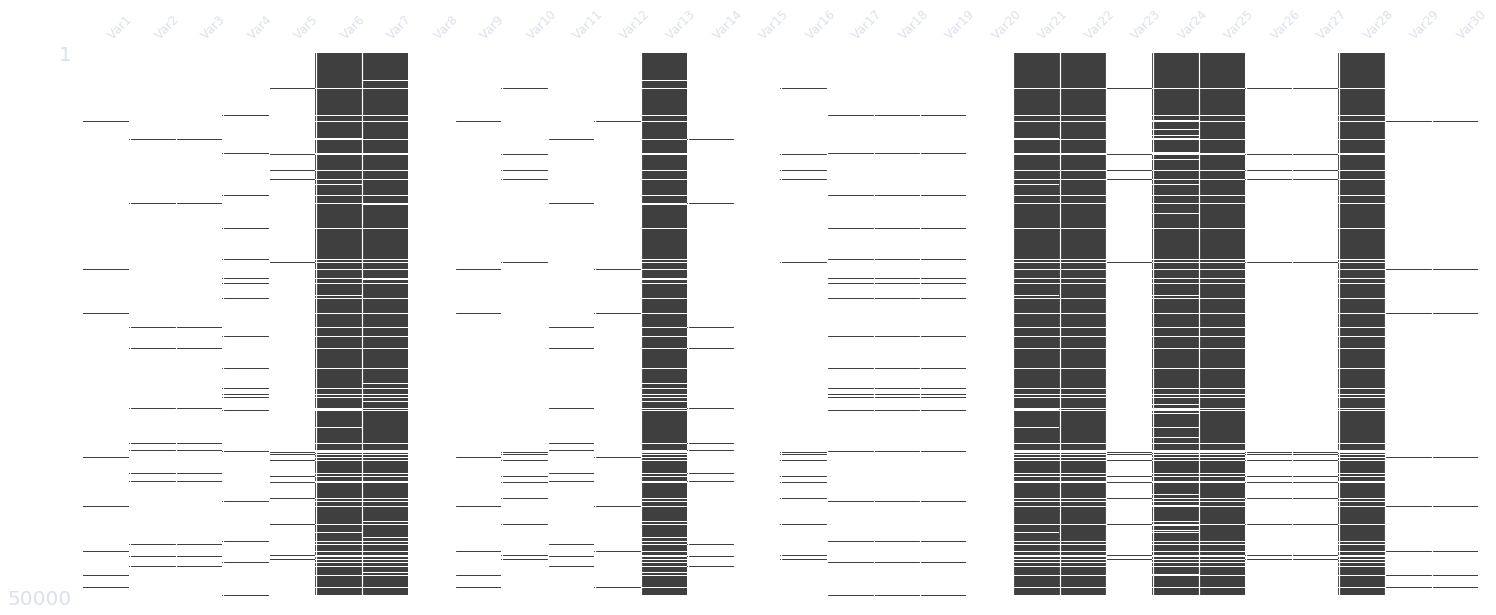

In [6]:
sample_df = features_raw.iloc[:, :30].copy()
viz.plot_missing_matrix(sample_df)

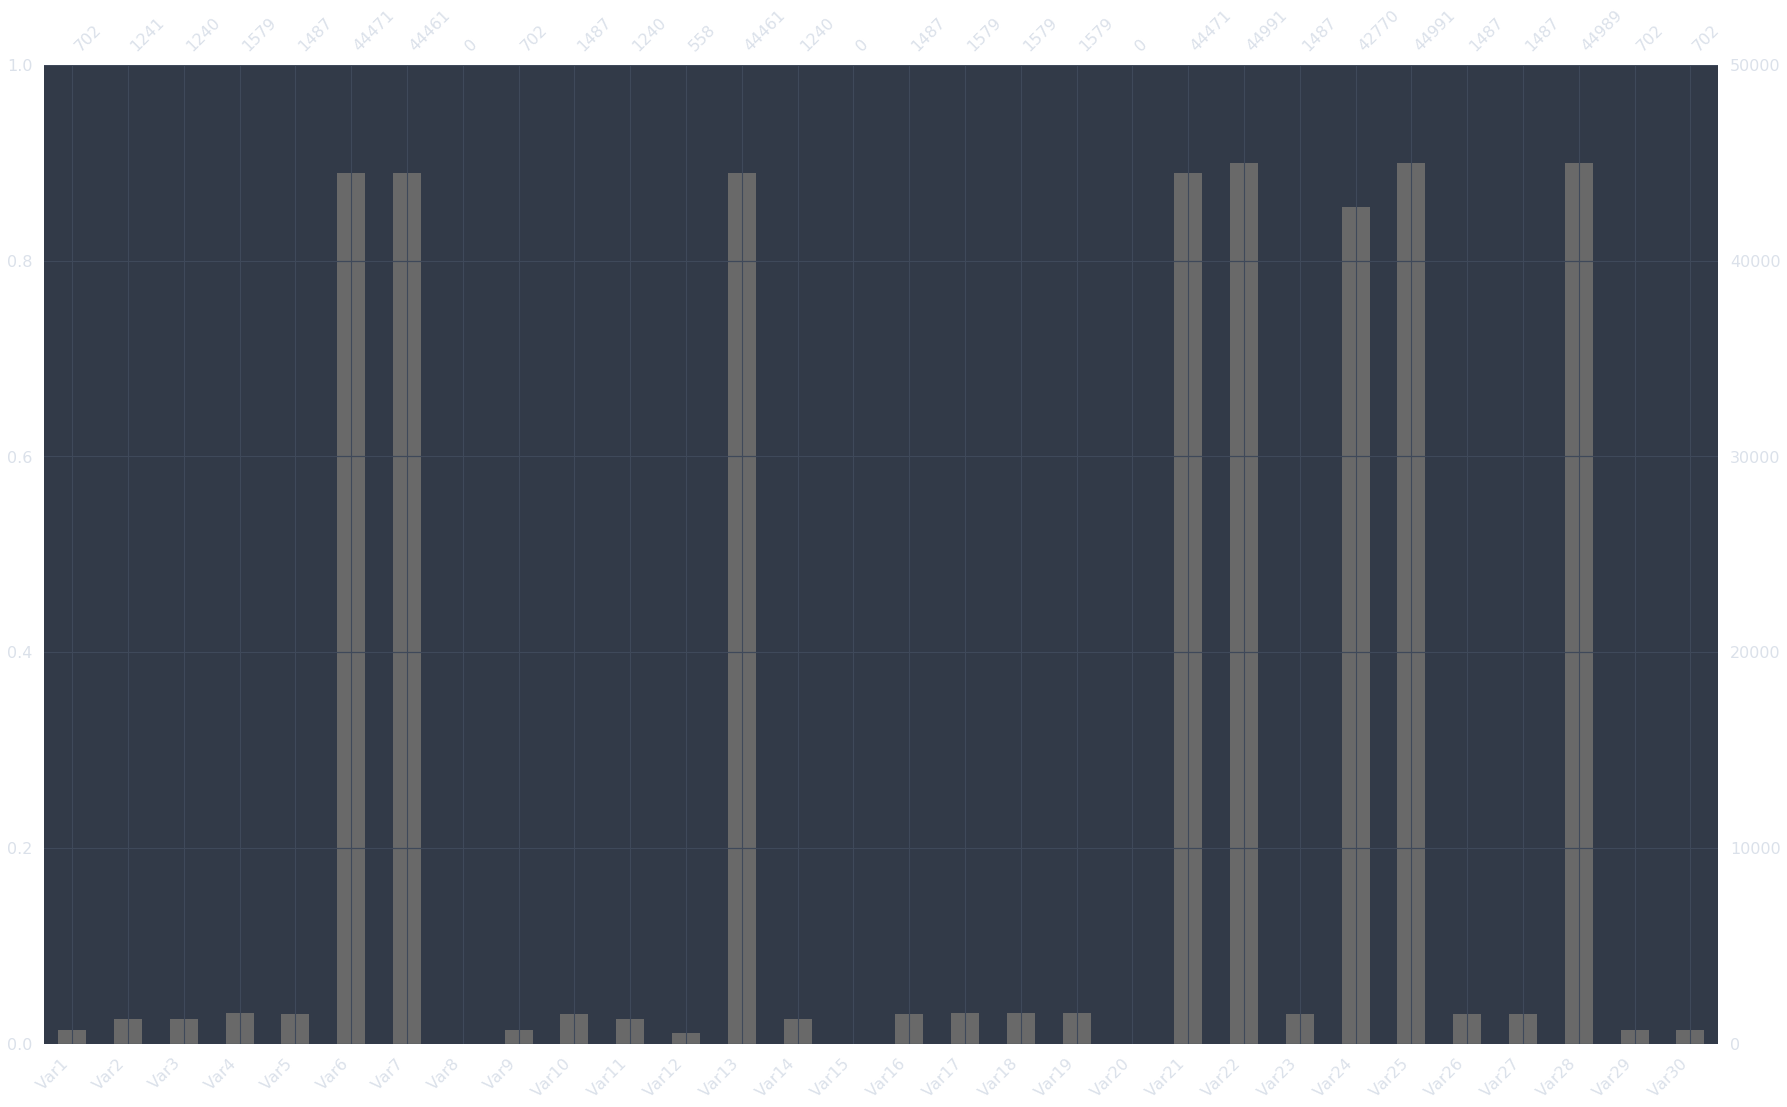

In [7]:
viz.plot_missing_bar(sample_df)

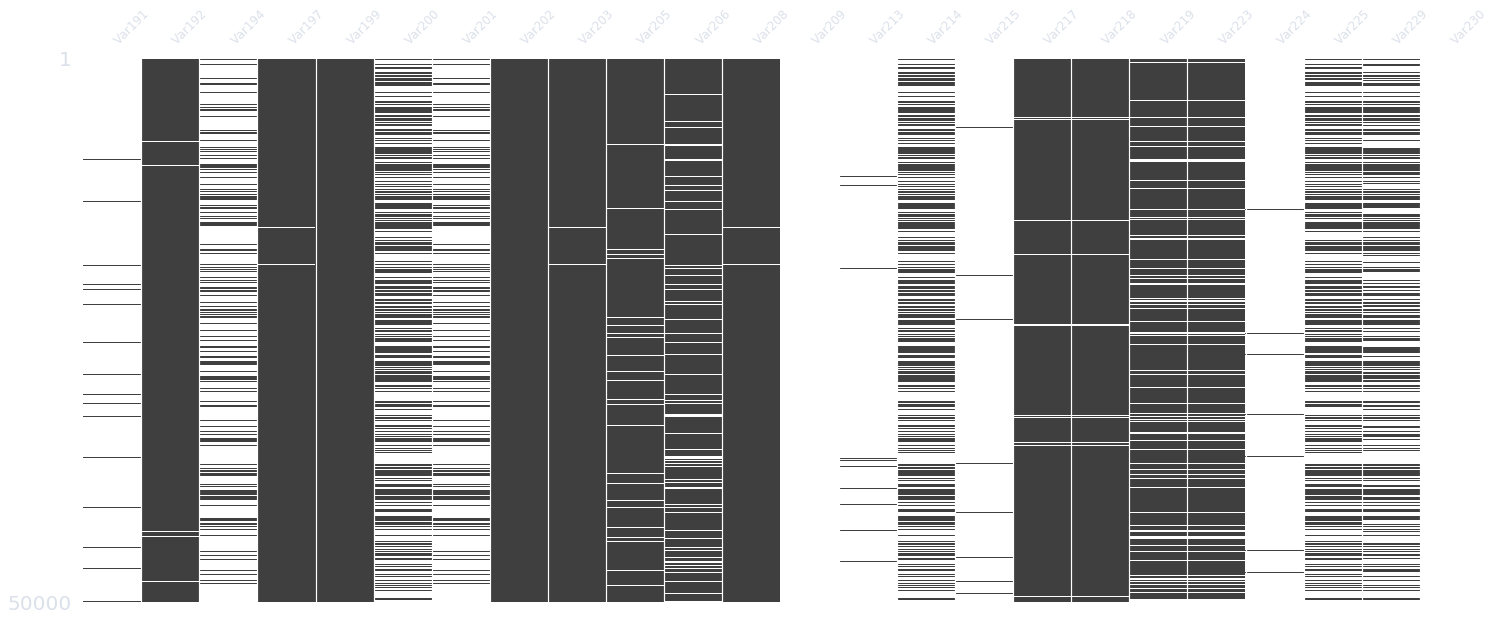

In [8]:
viz.plot_missing_matrix(categorical_features)

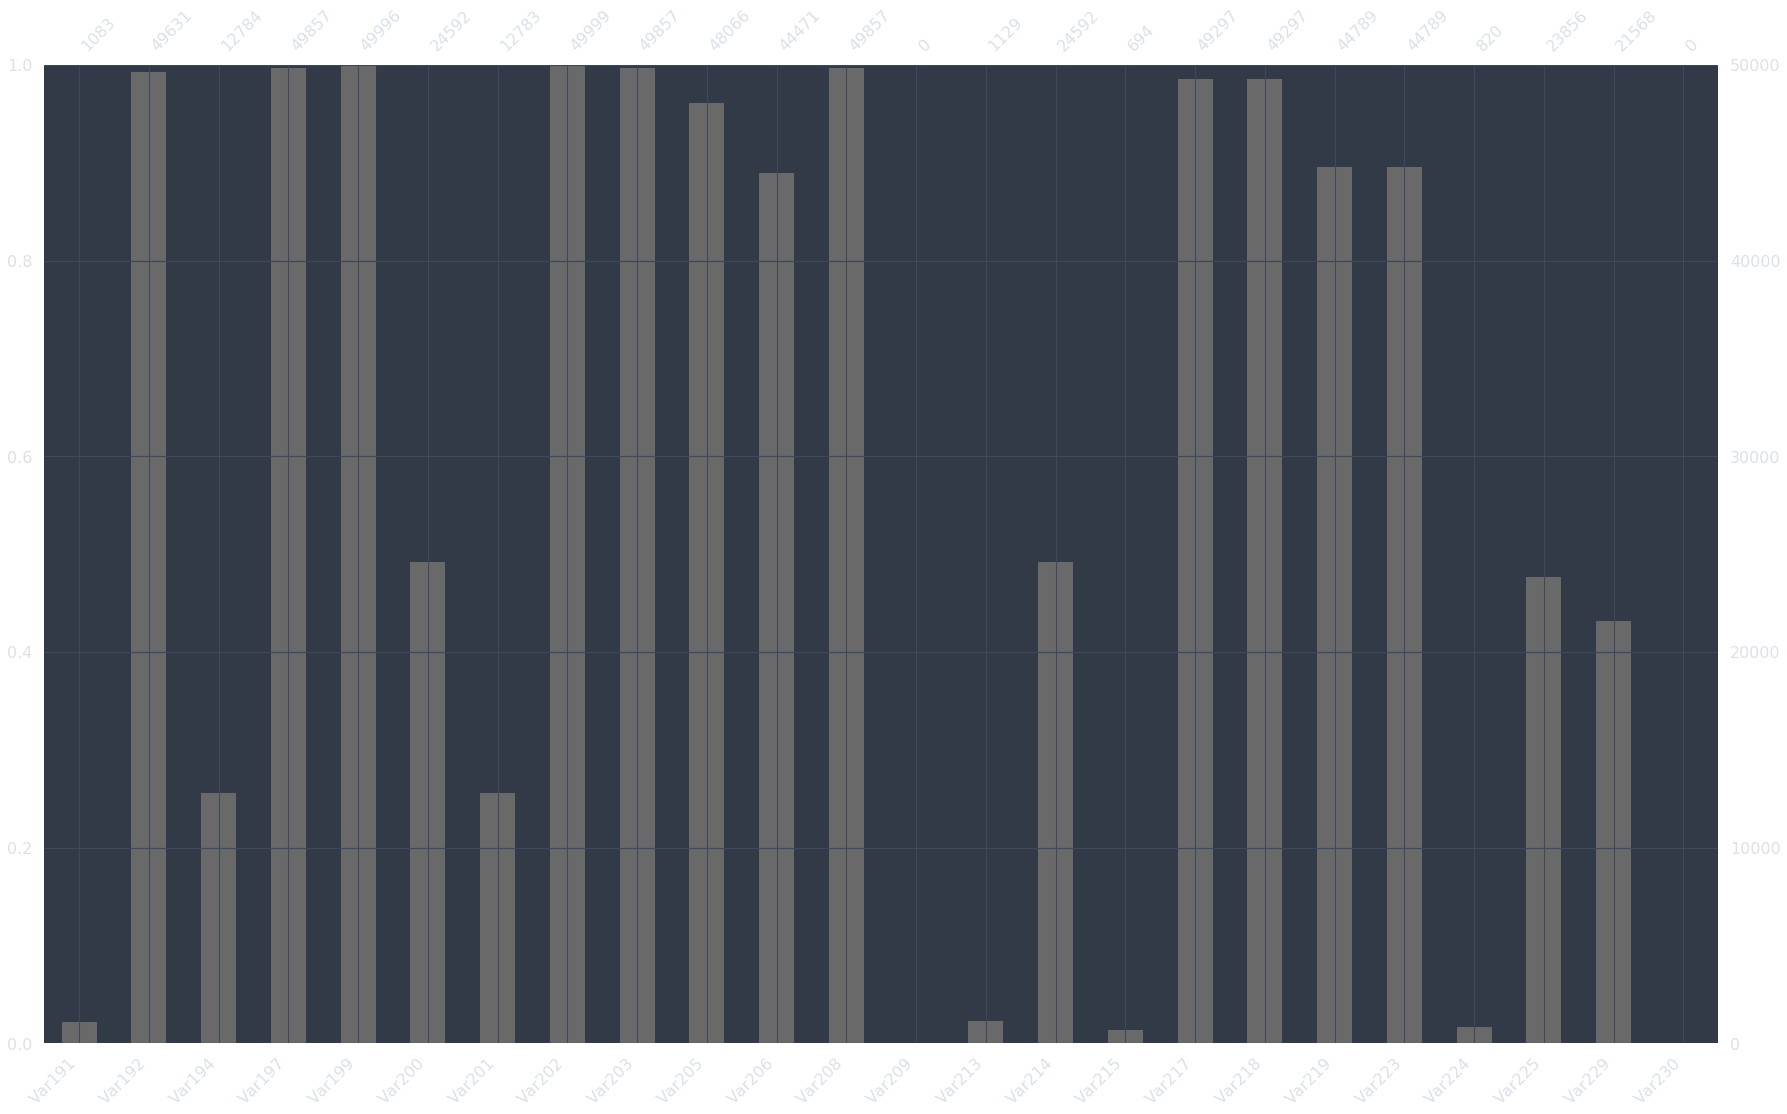

In [9]:
viz.plot_missing_bar(categorical_features)

As variáveis não existirem pode ser preditivo, mas vamos ignorar isso por enquanto e preencher o vazio com a média da instancia para features numericas e com a string 'missing' para as features categóricas (isso já é suficiente para predizer através do vazio)

(50000, 38)


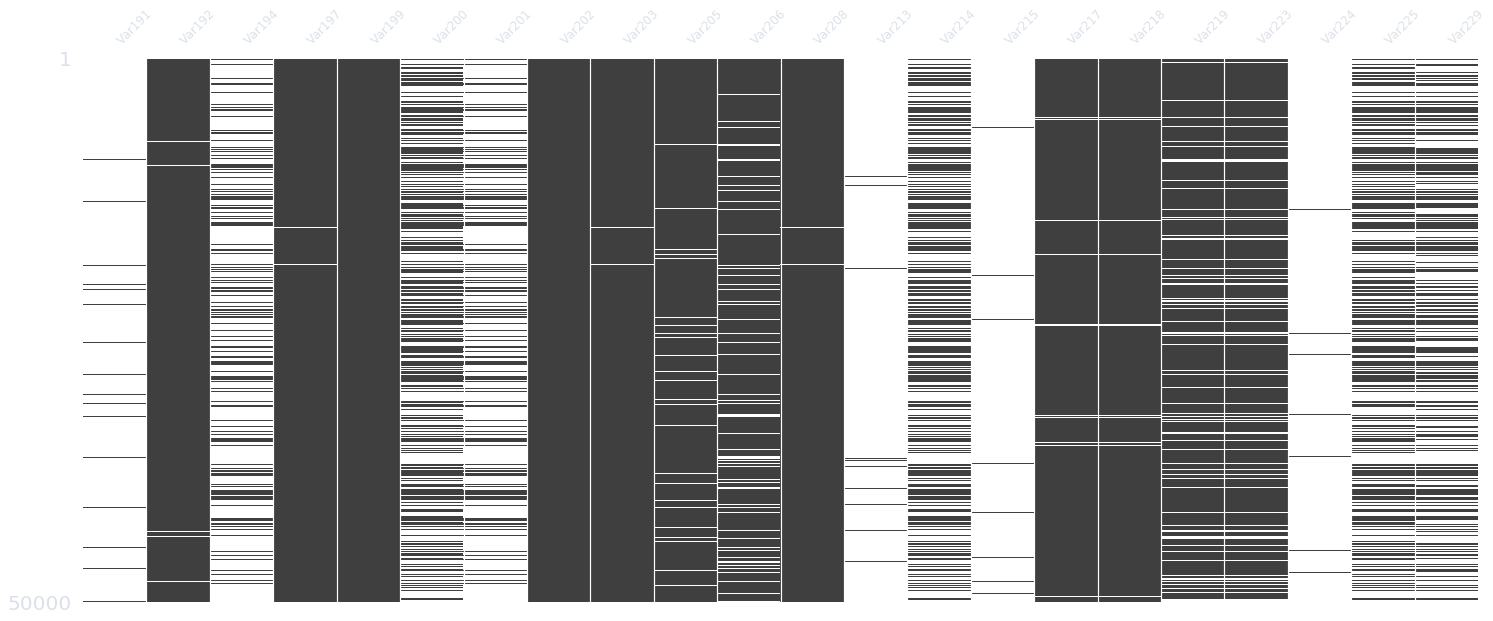

In [10]:
# Elimina as features que possuem o mesmo valor para todas as intâncias ou são exclusivamente nulas
categorical_features = utils.drop_min_unique_features(categorical_features, 1)

print(categorical_features.shape)
viz.plot_missing_matrix(categorical_features)

In [11]:
# Substitui vazio por 'missing'
categorical_features.fillna('missing', inplace=True)

categorical_features.astype('category', copy=False)

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,missing,bZkvyxLkBI,RO12,missing,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,missing,...,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,missing,missing,xb3V,RAYp,F2FyR07IdsN7I,missing
1,missing,CEat0G8rTN,RO12,missing,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,missing,...,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,missing,missing,fKCe,RAYp,F2FyR07IdsN7I,missing
2,missing,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,...,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,missing,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c
3,missing,jg69tYsGvO,RO12,missing,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,missing,...,L91KIiz,oslk,CE7uk3u,LM8l689qOp,missing,missing,FSa2,RAYp,F2FyR07IdsN7I,missing
4,missing,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,...,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,missing,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86
5,missing,m9SrEy7Rm6,2Knk1KF,missing,taul,1K8T,lK27,fayYfhR,etM739XNb0Rf0,missing,...,KbkKEj0,zCkv,QqVuch3,LM8l689qOp,missing,missing,Qcbd,02N6s8f,Zy3gnGM,am7c
6,missing,Qu0qrQKzJV,2Knk1KF,lvza,taul,1K8T,EJC9,ofiZR7x,LJF4fPp,QYxAlFM,...,JO03372,oslk,XlgxB9z,LM8l689qOp,missing,kG3k,FSa2,RAYp,55YFVY9,am7c
7,missing,eOQgUHShse,RO12,missing,LfvqpCtLOY,1K8T,Bxva,Xlthli9,GaiUdPAZp_,missing,...,U8IKsQe,oslk,R2LdzOv,missing,missing,missing,FSa2,RAYp,F2FyR07IdsN7I,missing
8,missing,4e7Wq69R_D,RO12,SEuy,taul,1K8T,0Xwj,6CXYbuk,okUBQrgaYWgG0,z1Qe5zX,...,ROeipLp,zCkv,K2SqEo9,jySVZNlOJy,missing,kG3k,PM2D,6fzt,am14IcfM7tWLrUmRT52KtA,am7c
9,missing,J9Vr4RQZiT,2Knk1KF,SEuy,taul,1K8T,kNzO,jwhtMxl,koda1Jh,A4emZtf,...,fabLnWA,oslk,EPqQcw6,LM8l689qOp,missing,kG3k,FSa2,RAYp,55YFVY9,missing


In [12]:
categorical_features.describe()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,...,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,2,362,51,4,23,4,226,4291,5074,15416,...,4291,7,4291,5,2,4,23,7,30,5
top,missing,qFpmfo8zhV,RO12,missing,taul,1K8T,0Xwj,fhk21Ss,r83_sZi,missing,...,4UxGlow,oslk,catzS2D,LM8l689qOp,missing,missing,FSa2,RAYp,F2FyR07IdsN7I,missing
freq,48917,385,35964,37216,47958,49550,4629,4441,955,25408,...,4441,37009,4441,36608,49180,26144,8031,35156,32703,28432


In [13]:
# Elimina as features que possuem o mesmo valor para todas as intâncias ou são exclusivamente nulas
numerical_features = utils.drop_min_unique_features(numerical_features, 1)

numerical_features.shape

(50000, 174)

In [14]:
# Substitui vazio pela média
numerical_features.fillna(numerical_features.mean(), inplace=True)

numerical_features.astype('float', copy=False)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var180,Var181,Var182,Var183,Var184,Var186,Var187,Var188,Var189,Var190
0,11.487179,0.004029,425.298387,0.125396,238793.32885,1526.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,462.000000,22007.045192
1,11.487179,0.004029,425.298387,0.125396,238793.32885,525.000000,0.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
2,11.487179,0.004029,425.298387,0.125396,238793.32885,5236.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
3,11.487179,0.004029,425.298387,0.125396,238793.32885,1326.437116,0.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
4,11.487179,0.004029,425.298387,0.125396,238793.32885,1029.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
5,11.487179,0.004029,425.298387,0.125396,238793.32885,658.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
6,11.487179,0.004029,425.298387,0.125396,238793.32885,1680.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,228.000000,22007.045192
7,11.487179,0.004029,425.298387,0.125396,238793.32885,77.000000,0.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
8,11.487179,0.004029,425.298387,0.125396,238793.32885,1176.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192
9,11.487179,0.004029,425.298387,0.125396,238793.32885,1141.000000,7.000000,48.145299,392605.656355,8.625806,...,3.776755e+06,0.000000,1.416638e+06,77773.795326,8.460919,3.299145,16.54416,167.368477,270.142137,22007.045192


In [15]:
numerical_features.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var180,Var181,Var182,Var183,Var184,Var186,Var187,Var188,Var189,Var190
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,...,5.000000e+04,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,48.145299,3.926057e+05,8.625806,...,3.776755e+06,0.611456,1.416638e+06,7.777380e+04,8.460919,3.299145,16.544160,167.368477,270.142137,22007.045192
std,4.820354,0.022352,672.206258,0.226593,1.110451e+05,2532.849475,5.965363,18.326822,1.599995e+05,0.451721,...,4.482539e+05,2.367372,4.050112e+05,3.175127e+04,7.397512,1.039849,7.130844,17.949779,56.221658,2370.061624
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,8.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-6.420000,6.000000,0.000000
25%,11.487179,0.004029,425.298387,0.125396,2.387933e+05,581.000000,0.000000,48.145299,3.926057e+05,8.625806,...,3.776755e+06,0.000000,1.416638e+06,7.777380e+04,8.460919,3.299145,16.544160,167.368477,270.142137,22007.045192
50%,11.487179,0.004029,425.298387,0.125396,2.387933e+05,945.000000,7.000000,48.145299,3.926057e+05,8.625806,...,3.776755e+06,0.000000,1.416638e+06,7.777380e+04,8.460919,3.299145,16.544160,167.368477,270.142137,22007.045192
75%,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,7.000000,48.145299,3.926057e+05,8.625806,...,3.776755e+06,0.000000,1.416638e+06,7.777380e+04,8.460919,3.299145,16.544160,167.368477,270.142137,22007.045192
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,2300.000000,1.232559e+07,40.000000,...,1.428483e+07,49.000000,1.199478e+07,3.048400e+06,1200.000000,102.000000,910.000000,628.620000,642.000000,230427.000000


Var191        2
Var192      362
Var193       51
Var194        4
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var200    15416
Var201        3
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var213        2
Var214    15416
Var215        2
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var224        2
Var225        4
Var226       23
Var227        7
Var228       30
Var229        5
dtype: int64


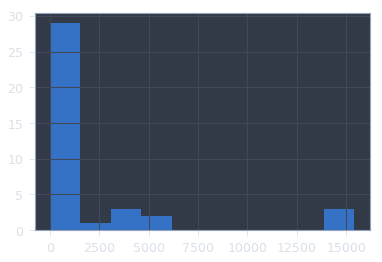

In [16]:
viz.plot_categories_per_feature(categorical_features)

Var191       2
Var192     362
Var193      51
Var194       4
Var195      23
Var196       4
Var197     226
Var198    4291
Var199    5074
Var201       3
Var202    5714
Var203       6
Var204     100
Var205       4
Var206      22
Var207      14
Var208       3
Var210       6
Var211       2
Var212      81
Var213       2
Var215       2
Var216    2016
Var218       3
Var219      23
Var220    4291
Var221       7
Var222    4291
Var223       5
Var224       2
Var225       4
Var226      23
Var227       7
Var228      30
Var229       5
dtype: int64


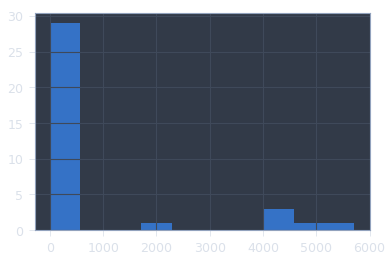

In [17]:
categorical_features = utils.drop_max_unique_features(categorical_features, 6000)
viz.plot_categories_per_feature(categorical_features)

In [18]:
features = pd.concat((numerical_features, categorical_features), axis=1)

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier

Cria uma cópia do dataset para predicao do churn
Calcula a importancia das features (quais features realmente impactam a predição)

In [25]:
churn_features = pd.get_dummies(features)

In [26]:
churn_labels = pd.read_csv(path + 'orange_small_train_churn.labels', header = None)

In [27]:
def get_features_importances(features, outcome):
    max_depth = 3
    learning_rate = 0.1
    n_estimators = 200
    
    model = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        silent=False,
        objective='binary:logistic',
        tree_method= 'gpu_hist',
        nthread=-1,
        seed=73,
    )
    model.fit(features, np.array(outcome).ravel())
    
    importances = model.feature_importances_
    variables = np.array(features.columns)
    
    return variables, importances

In [28]:
variables, importances = get_features_importances(churn_features, churn_labels)

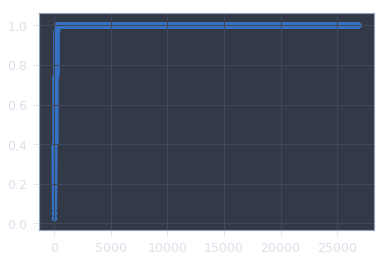

In [29]:
churn_summed_importances = viz.plot_summed_importances(variables, importances)

A importancia do modelo cresce rapidamente e logo chega em um plateau. Vamos descartar as variáveis de menos importância

In [30]:
def remove_unimportant_vars(features, summed_importances, threshold=0.99):
    important_vars = list(summed_importances[summed_importances.iloc[:,1] <= threshold].iloc[:,0])
    features = features.loc[:, important_vars]
    
    return features

In [31]:
churn_features = remove_unimportant_vars(churn_features, churn_summed_importances)

In [32]:
churn_features.shape

(50000, 227)

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [34]:
def split_dataset(features, labels, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, stratify=labels, random_state=73)
    y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
    
    return X_train, X_test, y_train, y_test

In [35]:
# Get a small subset (20%) just to check the classifiers
_, X_train, _, y_train = split_dataset(churn_features, churn_labels)

In [36]:

# libs basicas data science
from sklearn import datasets
import numpy as np
import pandas as pd
from scipy import stats
import math

#libs visualizacao
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML
from mlxtend.plotting import plot_decision_regions

#sklean model selection http://scikit-learn.org/
from sklearn.model_selection import cross_val_score, train_test_split

#sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [85]:
models = {}
models['LR'] = LogisticRegression(solver='lbfgs')
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier(random_state=73)
models['NB'] = GaussianNB()
models['SVC'] = SVC(probability=True)
models['XGB'] = XGBClassifier(objective='binary:logistic', tree_method= 'gpu_hist', seed=73)
models['RFC'] = RandomForestClassifier(random_state=73)
models['GBC'] = GradientBoostingClassifier(random_state=73)

In [41]:
def train_and_report(models, X, y):
    results = []
    for name in models.keys():
        model = models[name]
        scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        print("AUC: %.3f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), name))

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
train_and_report(models, X_train, y_train)

AUC: 0.559 (+/- 0.005) [LR]
AUC: 0.699 (+/- 0.004) [LDA]


KeyboardInterrupt: 

Agora que sabemos o melhor modelo para a tarefa, vamos otimizar alguns parametros. Utilizar grid search p/ otimizar

In [108]:
def churn_model_optimizer(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, params, cv=5):
    np.random.seed(0)

    model = GradientBoostingClassifier(n_estimators=n_estimators, 
                                       learning_rate=learning_rate,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf, 
                                       max_depth=max_depth, 
                                       max_features=max_features, 
                                       subsample=subsample, 
                                       random_state=0)

    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               scoring='roc_auc', 
                               n_jobs=1, 
                               iid=False, 
                               cv=cv)

    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)
    
    return model, best_params, best_score

In [109]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [110]:
learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 151, 10)}

model, opt_param, score = churn_model_optimizer( n_estimators = n_estimators,
                                                 learning_rate = learning_rate,
                                                 min_samples_split = min_samples_split,
                                                 min_samples_leaf = min_samples_leaf,
                                                 max_depth = max_depth,
                                                 max_features = max_features,
                                                 subsample = subsample,
                                                 params = params)

{'n_estimators': 90} 0.7399702294336741


In [111]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [114]:
n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 5, 'min_samples_split': 300} 0.7057825854232878


In [115]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [116]:
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 30} 0.7059697513083983


In [117]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [118]:
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 25} 0.709992303079779


In [119]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [120]:
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.8000000000000002} 0.709992303079779


In [121]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [161]:
def churn_lr_optimizer(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, params, cv=5, dividers=[2,5,2,5,2]):
    models = np.array([])
    scores = np.array([])
    
    for div in dividers:
        np.random.seed(0)
        
        learning_rate /= div
        n_estimators *= div
        
        model = GradientBoostingClassifier(n_estimators = n_estimators, 
                                         learning_rate = learning_rate,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf, 
                                         max_depth = max_depth, 
                                         max_features = max_features, 
                                         subsample = subsample, 
                                         random_state = 0)

        cv_scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=1)
        scores = np.append(scores, cv_scores.mean())
        plt.plot(np.append(scores, score))
        plt.title('n_estimators = {} ... learning_rate = {}'.format(n_estimators, learning_rate))
        
        print('n_estimators: {} | learning_rate: {} | score: {}'.format(n_estimators, learning_rate, cv_scores.mean()))
        
        models = np.append(models, model)

    return models, scores

[2, 5, 2, 5, 2]
Iteration 2
n_estimators: 180 | learning_rate: 0.05 | score: 0.7143677090802811
Iteration 5
n_estimators: 900 | learning_rate: 0.01 | score: 0.7117610530366624
Iteration 2
n_estimators: 1800 | learning_rate: 0.005 | score: 0.7137553962697767
Iteration 5
n_estimators: 9000 | learning_rate: 0.001 | score: 0.7134988155640741
Iteration 2
n_estimators: 18000 | learning_rate: 0.0005 | score: 0.7138359177750149


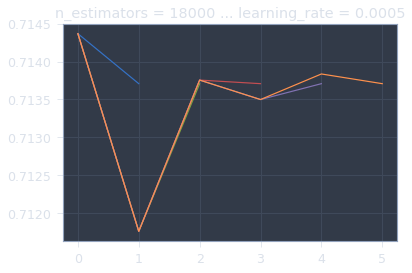

In [162]:
subsample = opt_params['subsample']
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

models, scores = churn_lr_optimizer(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [163]:
models = np.append(models, models)
scores = np.append(scores, scores)

In [164]:
print('Best performance: {} | Model: {}'.format(max(scores), scores.argmax()))

Best performance: 0.7143677090802811 | Model: 0


In [165]:
X_train, X_test, y_train, y_test = split_dataset(churn_features, churn_labels)

In [ ]:
!pip install pickle

In [ ]:
import pickle

In [ ]:
churn_model = models[scores.argmax()]
churn_model.fit(X_train, y_train)

In [ ]:
path = './models/'
filename = path + 'final_churn_model.sav'
pickle.dump(churn_model, open(filename, 'wb'))

In [ ]:
churn_predictions = churn_model.predict_proba(X_test)
roc_auc_score(y_test, churn_predictions[:, 1])

Start appetency

In [ ]:
appetency_features = pd.get_dummies(features)
appetency_labels = pd.read_csv(path + 'orange_small_train_appetency.labels', header = None)

In [ ]:
variables, importances = get_features_importances(appetency_features, appetency_labels)
appetency_summed_importances = viz.plot_summed_importances(variables, importances)
appetency_features = remove_unimportant_vars(appetency_features, appetency_summed_importances)

In [ ]:
# Get a small subset (20%) just to check the classifiers
_, X_train, _, y_train = split_dataset(appetency_features, appetency_labels)

In [ ]:
models = {}
models['LR'] = LogisticRegression(solver='lbfgs')
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier(random_state=73)
models['NB'] = GaussianNB()
models['SVC'] = SVC(probability=True)
models['XGB'] = XGBClassifier(objective='binary:logistic', tree_method= 'gpu_hist', seed=73)
models['RFC'] = RandomForestClassifier(random_state=73)
models['GBC'] = GradientBoostingClassifier(random_state=73)

In [ ]:
train_and_report(models, X_train, y_train)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
subsample = opt_params['subsample']
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

models, scores = churn_lr_optimizer(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params,
                        dividers=dividers)

In [ ]:
models = np.append(models, models)
scores = np.append(scores, scores)

In [ ]:
print('Best performance: {} | Model: {}'.format(max(scores), scores.argmax()))

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(appetency_features, appetency_labels)

In [ ]:
appetency_model = models[scores.argmax()]
appetency_model.fit(X_train, y_train)

In [ ]:
path = './models/'
filename = path + 'final_appetency_model.sav'
pickle.dump(appetency_model, open(filename, 'wb'))

In [ ]:
appetency_predictions = appetency_model.predict_proba(X_test)
roc_auc_score(y_test, appetency_predictions[:, 1])

Start upselling

In [ ]:
upselling_features = pd.get_dummies(features)
upselling_labels = pd.read_csv(path + 'orange_small_train_upselling.labels', header = None)

In [ ]:
variables, importances = get_features_importances(upselling_features, upselling_labels)
upselling_summed_importances = viz.plot_summed_importances(variables, importances)
upselling_features = remove_unimportant_vars(upselling_features, upselling_summed_importances)

In [ ]:
# Get a small subset (20%) just to check the classifiers
_, X_train, _, y_train = split_dataset(upselling_features, upselling_labels)

In [ ]:
models = {}
models['LR'] = LogisticRegression(solver='lbfgs')
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier(random_state=73)
models['NB'] = GaussianNB()
models['SVC'] = SVC(probability=True)
models['XGB'] = XGBClassifier(objective='binary:logistic', tree_method= 'gpu_hist', seed=73)
models['RFC'] = RandomForestClassifier(random_state=73)
models['GBC'] = GradientBoostingClassifier(random_state=73)

In [ ]:
train_and_report(models, X_train, y_train)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

model, opt_param, score = churn_model_optimizer(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [ ]:
models = np.append(models, model)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [ ]:
subsample = opt_params['subsample']
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

models, scores = churn_lr_optimizer(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params,
                        dividers=dividers)

In [ ]:
models = np.append(models, models)
scores = np.append(scores, scores)

In [ ]:
print('Best performance: {} | Model: {}'.format(max(scores), scores.argmax()))

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(upselling_features, upselling_labels)

In [ ]:
upselling_model = models[scores.argmax()]
upselling_model.fit(X_train, y_train)

In [ ]:
path = './models/'
filename = path + 'final_upselling_model.sav'
pickle.dump(upselling_model, open(filename, 'wb'))

In [ ]:
upselling_predictions = upselling_model.predict_proba(X_test)
roc_auc_score(y_test, upselling_predictions[:, 1])